In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Libraries

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
from torchvision import datasets, models, transforms

import os
import copy
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import tqdm.notebook as tqdm
from multiprocessing.pool import Pool
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report

cudnn.benchmark = True
plt.ion()   # interactive mode

### Get dataset

In [ ]:
data_transforms = {
    'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.485, 0.456, 0.406], 
                    [0.229, 0.224, 0.225]
                )
    ]),
    'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.485, 0.456, 0.406], 
                    [0.229, 0.224, 0.225]
                )
    ]),
    'test': transforms.Compose([ 
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(), 
                transforms.Normalize(
                    [0.485, 0.456, 0.406], 
                    [0.229, 0.224, 0.225]
                )
    ]),
}

data_dir = '/content/drive/MyDrive/COURSES/CS331/FinalProject/dataset/GraphCXR/CXR_Reformat_Resize/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True, num_workers=4)
                for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
dataset_sizes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'test': 624, 'train': 4193, 'val': 1049}

### Plot classify report

In [ ]:
def plot_cm(cm, display_labels, path_fig):
    font = {"size": 20}
    matplotlib.rc("font", **font) 
    f, axes = plt.subplots(1, 1, figsize=(7, 7), sharey="row")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=axes, xticks_rotation=45, cmap="Blues", values_format='d')
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel("Predicted label", fontsize=20)
    disp.ax_.set_ylabel("True label", fontsize=20) 
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.show()

### Load and test ResNet50 model

In [ ]:
model_resnet = models.resnet50(pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

cnt = 0
for param in model_resnet.parameters():
    if cnt < 161 * 3 // 4:
        param.requires_grad = False
    else:
        break
    cnt += 1
num_ftrs    = model_resnet.fc.in_features  
model_resnet.fc = nn.Linear(num_ftrs, 3) 
model_resnet    = model_resnet.to(device)

model_resnet.load_state_dict(torch.load('/content/drive/MyDrive/COURSES/CS331/FinalProject/ResNet50.pt') 

<All keys matched successfully>

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0     0.8750    0.9545    0.9130       242
           1     0.9825    0.7179    0.8296       234
           2     0.6561    0.8378    0.7359       148

    accuracy                         0.8381       624
   macro avg     0.8378    0.8368    0.8262       624
weighted avg     0.8634    0.8381    0.8397       624



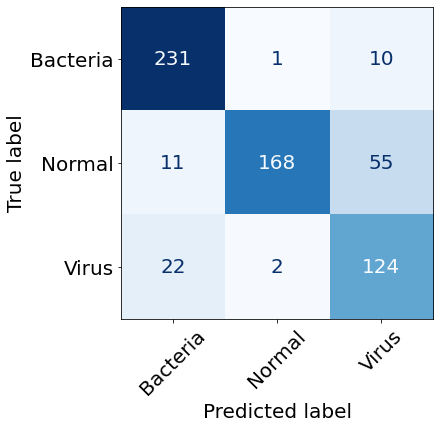

In [ ]:
model_resnet.eval()
correct = 0
y_pred = []
y_true = []
for inputs, labels in tqdm.tqdm(dataloaders['test']): 
    out = model_resnet(inputs)  
    _, preds = torch.max(out, 1) 
     
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(np.squeeze(preds.cpu().numpy().T))
     
report = classification_report(y_true, y_pred, digits=4)
print(report)
cm = confusion_matrix(y_true, y_pred)

display_labels = ['Bacteria', 'Normal', 'Virus'] 
plot_cm(cm=cm, display_labels=display_labels, path_fig='/content/drive/MyDrive/COURSES/CS331/FinalProject/test_resnet50.pdf')

### Load and test VGG16 model

In [ ]:
model_vgg16 = models.vgg16(pretrained=True)
cnt = 0
for param in model_vgg16.parameters():
    if cnt < 32 * 3 // 4:
        param.requires_grad = False
    else:
        break
    cnt += 1
num_ftrs = model_vgg16.classifier[6].in_features 
model_vgg16.fc = nn.Linear(num_ftrs, 3)

model_vgg16 = model_vgg16.to(device)
model_vgg16.load_state_dict(torch.load('/content/drive/MyDrive/COURSES/CS331/FinalProject/VGG16.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0     0.7657    0.9587    0.8514       242
           1     0.9524    0.6838    0.7960       234
           2     0.7124    0.7365    0.7243       148

    accuracy                         0.8029       624
   macro avg     0.8102    0.7930    0.7905       624
weighted avg     0.8231    0.8029    0.8005       624



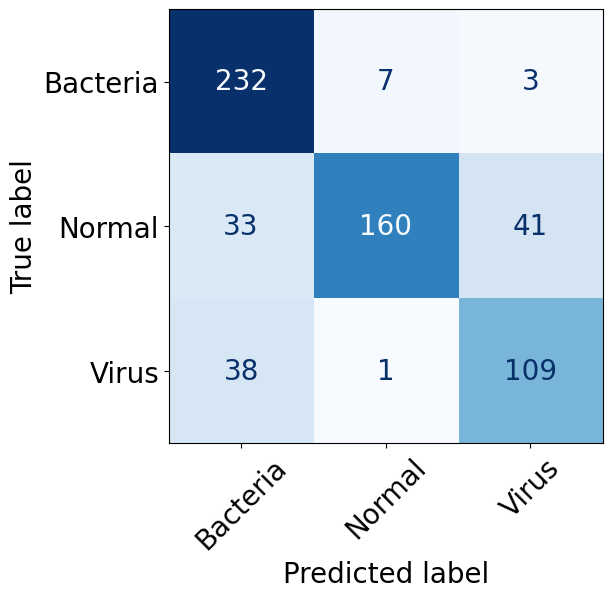

In [ ]:
model_vgg16.eval()
correct = 0
y_pred = []
y_true = []
for inputs, labels in tqdm.tqdm(dataloaders['test']): 
    out = model_vgg16(inputs)  
    _, preds = torch.max(out, 1) 
     
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(np.squeeze(preds.cpu().numpy().T))
     
report = classification_report(y_true, y_pred, digits=4)
print(report)
cm = confusion_matrix(y_true, y_pred)

display_labels = ['Bacteria', 'Normal', 'Virus'] 
plot_cm(cm=cm, display_labels=display_labels, path_fig='/content/drive/MyDrive/COURSES/CS331/FinalProject/test_resnet50.pdf')

### Revisualise resnet and vgg16

In [ ]:
train_acc_resnet = [0.6389,0.7183,0.7391,0.7491 ,0.7544 ,0.7589 ,0.7653 ,0.7591 ,0.7739,0.7792,0.7753,0.7787,0.7801,0.7827,0.7820,0.7956,0.7839,0.8035,0.8111,0.8097,0.8059,0.8121,0.8147,0.8106,0.8087,0.8118,0.8114,0.8159,0.8159,0.8128,0.8259,0.8185,0.8154,0.8168,0.8102,0.8161,0.8156,0.8209,0.8164,0.8183,0.8187,0.8109,0.8125,0.8133,0.8135,0.8123,0.8159,0.8140,0.8104,0.8109]
train_loss_resnet = [0.8181,0.6504,0.6133,0.5862,0.5686,0.5504,0.5529,0.5475,0.5327,0.5215,0.5210,0.5071,0.4995,0.4998,0.5040,0.4784,0.4888,0.4550,0.4383,0.4408,0.4369,0.4243,0.4340,0.4319,0.4334,0.4281,0.4303,0.4220,0.4320,0.4338,0.4185,0.4238,0.4219,0.4239,0.4339,0.4181,0.4325,0.4160,0.4205,0.4278,0.4269,0.4243,0.4324,0.4317,0.4294,0.4282,0.4211,0.4256,0.4255,0.4255]
val_acc_resnet = [0.7655,0.7922,0.7922,0.7979,0.7950,0.7989,0.7331,0.8074,0.8132,0.8160,0.8236,0.7598,0.8198,0.8132,0.8103,0.8141,0.8208,0.8322,0.8427,0.8389,0.8398,0.8398,0.8398,0.8341,0.8398,0.8427,0.8398,0.8427,0.8360,0.8389,0.8360,0.8379,0.8360,0.8437,0.8418,0.8389,0.8398,0.8427,0.8351,0.8427,0.8437,0.8408,0.8398,0.8418,0.8437,0.8446,0.8427,0.8456,0.8437,0.8398]
val_loss_resnet = [0.5510,0.5032,0.5489,0.5146,0.4672,0.4784,0.6669,0.4487,0.4481,0.4477,0.4127,0.4995,0.3957,0.4343,0.4321,0.4191,0.4185,0.3976,0.3863,0.3735,0.3814,0.3865,0.3856,0.3940,0.3817,0.3758,0.3825,0.3806,0.3826,0.3841,0.3835,0.3791,0.3913,0.3791,0.3806,0.3940,0.3815,0.3814,0.3771,0.3799,0.3743,0.3847,0.3823,0.3776,0.3830,0.3855,0.3774,0.3890,0.3769,0.3796]

In [ ]:
train_acc_vgg16 = [0.5426,0.6153,0.6332,0.6349,0.6361,0.6396,0.6406,0.6423,0.6482,0.6632,0.6566,0.6735,0.6742,0.6840,0.6933,0.7000,0.7157,0.7136,0.7217,0.7267,0.7408,0.7386,0.7389,0.7451,0.7508,0.7548,0.7515,0.7606,0.7622,0.7646,0.7641,0.7625,0.7672,0.7691,0.7734,0.7770,0.7651,0.7761,0.7737,0.7744,0.7727,0.7744,0.7758,0.7715,0.7768,0.7691,0.7725,0.7741,0.7699,0.7794]
train_loss_vgg16 = [1.3748,0.9629,0.8764,0.8819,0.8405,0.8788,0.8727,0.8216,0.7866,0.7556,0.7636,0.7353,0.7304,0.7165,0.7040,0.6797,0.6686,0.6547,0.6397,0.6326,0.6169,0.6089,0.6045,0.6022,0.5725,0.5887,0.5853,0.5825,0.5550,0.5550,0.5578,0.5597,0.5559,0.5510,0.5406,0.5416,0.5527,0.5382,0.5374,0.5470,0.5390,0.5365,0.5412,0.5435,0.5317,0.5359,0.5410,0.5403,0.5368,0.5309]
val_acc_vgg16 = [0.6616,0.6511,0.7102,0.6969,0.6969,0.6511,0.698,0.7083,0.7169,0.7188,0.7178,0.7731,0.7779,0.7807,0.7684,0.7979,0.7950,0.7855,0.7950,0.7931,0.7865,0.7979,0.7903,0.8008,0.8074,0.7960,0.8055,0.8065 ,0.8074,0.8103,0.8132,0.8084,0.8055,0.8065,0.8036,0.8027,0.8065,0.8017,0.8093,0.8065,0.8036,0.8065,0.8046,0.8093 ,0.8084,0.8074,0.8084,0.8065,0.8074,0.8084]
val_loss_vgg16 = [0.8426,0.7908,0.6523,0.7061,0.7000,0.8041,0.7163,0.6649,0.6490,0.6393,0.6285,0.5713,0.5672,0.5557,0.5605,0.5306,0.5284,0.5148,0.5150,0.5186,0.5066,0.4955,0.5135,0.4860,0.4898,0.4978,0.4895,0.4998,0.4879,0.4826,0.4817,0.4851,0.4826,0.4753,0.4811,0.4789,0.4746,0.4746,0.4723,0.4713,0.4770,0.4753,0.4745,0.4727,0.4739,0.4739,0.4739,0.4743,0.4742,0.4733]